In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Load and filter data from last 10 years
- I'm including the option to filter out specific years, if you want
- For example, years where COVID appear to have a clear impact on death rates and immigration rates (I looked at the rates for each year on the UN website to determine which ones seemed like COVID artificacts)
    - NOTE: Removing these COVID years chanes the projections quite a bit

In [13]:
# Load and filter data from last 10 years
# Make a dataset for countries and rates (source: https://population.un.org/dataportal/data/indicators/55,59,66/locations/566,410,858/start/2015/end/2025/table/pivotbylocation?df=a4393818-6164-40b2-8d91-cc7bc84450a1)
# Current populations source: https://www.worldometers.info/world-population/population-by-country/
# Crude birth rate is live births/population/year
# Crude death rate is deaths/thousand/year
# Net migration rate is migrations/thousand/year (positive is immigration, negative is emmigration)

# Load datasets
birth_rates = pd.read_csv("/Users/mgreeson/miniconda3/envs/bio265/bio265_final/crude_birth_unpopulation_dataportal_20250311132101.csv")
death_rates = pd.read_csv("/Users/mgreeson/miniconda3/envs/bio265/bio265_final/crude_death_unpopulation_dataportal_20250311132154.csv")
migration_rates = pd.read_csv("/Users/mgreeson/miniconda3/envs/bio265/bio265_final/migration_unpopulation_dataportal_20250311132823.csv")

# Define populations
populations = {
    "Republic of Korea": 51717590,
    "Nigeria": 232679478,
    "Uruguay": 3386588
}

# Filter to the last 10 years and exclude specified values
recent_years = list(range(2014, 2024))  # Last 10 years

birth_rates = birth_rates[birth_rates["Time"].isin(recent_years)]
death_rates = death_rates[death_rates["Time"].isin(recent_years)]
migration_rates = migration_rates[migration_rates["Time"].isin(recent_years)]

# Exclude specific data points
# migration_rates = migration_rates[~((migration_rates["Location"] == "Republic of Korea") & (migration_rates["Time"] == 2021))]
# death_rates = death_rates[~((death_rates["Location"] == "Republic of Korea") & (death_rates["Time"] == 2022))]
# death_rates = death_rates[~((death_rates["Location"] == "Uruguay") & ((death_rates["Time"] == 2021) | (death_rates["Time"] == 2022)))]

### Define function to sample birth, death, and migration rates for bootstrapping
- Note: I am weighting more recent years by exponential weighting, with the assumption that more recent rates are better indicators of future trends

In [14]:
# Function to sample birth, death, and migration rates for bootstrapping, weighting rates from more recent years
def sample_rates(country):
    # Get the relevant data for the country
    country_birth_rates = birth_rates[birth_rates["Location"] == country]
    country_death_rates = death_rates[death_rates["Location"] == country]
    country_migration_rates = migration_rates[migration_rates["Location"] == country]

    # Define weights: more recent years get higher weights
    def compute_weights(df):
        
        years = df["Time"]
        weights = np.exp((years - years.min()) / 2)  # Exponential weighting
        return weights / weights.sum()  # Normalize to sum to 1

    birth_weights = compute_weights(country_birth_rates)
    death_weights = compute_weights(country_death_rates)
    migration_weights = compute_weights(country_migration_rates)

    # Sample with replacement using weights
    birth_sample = np.random.choice(country_birth_rates["Value"], p=birth_weights)
    death_sample = np.random.choice(country_death_rates["Value"], p=death_weights)
    migration_sample = np.random.choice(country_migration_rates["Value"], p=migration_weights)

    return birth_sample, death_sample, migration_sample

### Projections
- Define ODE function for population dynamics
- Define Function to simulate population projections with bootstrapping
- Compute mean projection and 95% CI

In [15]:
# ODE function for population dynamics
def pop_dynamics(var, t, params):
    population = var[0]
    birth_rate, death_rate, mig_rate = params
    
    dpop_dt = (population / 1000) * birth_rate + (population / 1000) * mig_rate - (population / 1000) * death_rate
    return [dpop_dt]

# Function to simulate population projections with bootstrapping
def bootstrap_population_projection(country, n_years=10, n_bootstrap=1000):
    t_vals = np.arange(n_years + 1)
    pop_trajectories = []

    for _ in range(n_bootstrap):
        birth_rate, death_rate, mig_rate = sample_rates(country)
        params = [birth_rate, death_rate, mig_rate]
        pop_init = [populations[country]]
        pop_proj = odeint(pop_dynamics, pop_init, t_vals, args=(params,))
        pop_trajectories.append(pop_proj.flatten())

    pop_trajectories = np.array(pop_trajectories)

    # Compute mean and 95% CI
    mean_projection = np.mean(pop_trajectories, axis=0)
    lower_CI = np.percentile(pop_trajectories, 2.5, axis=0)
    upper_CI = np.percentile(pop_trajectories, 97.5, axis=0)

    return t_vals, mean_projection, lower_CI, upper_CI

### Plot projections 
- Include mean projection with 95% CI
- Note: I kinda arbitrarily chose the y axis to visualize things nicely

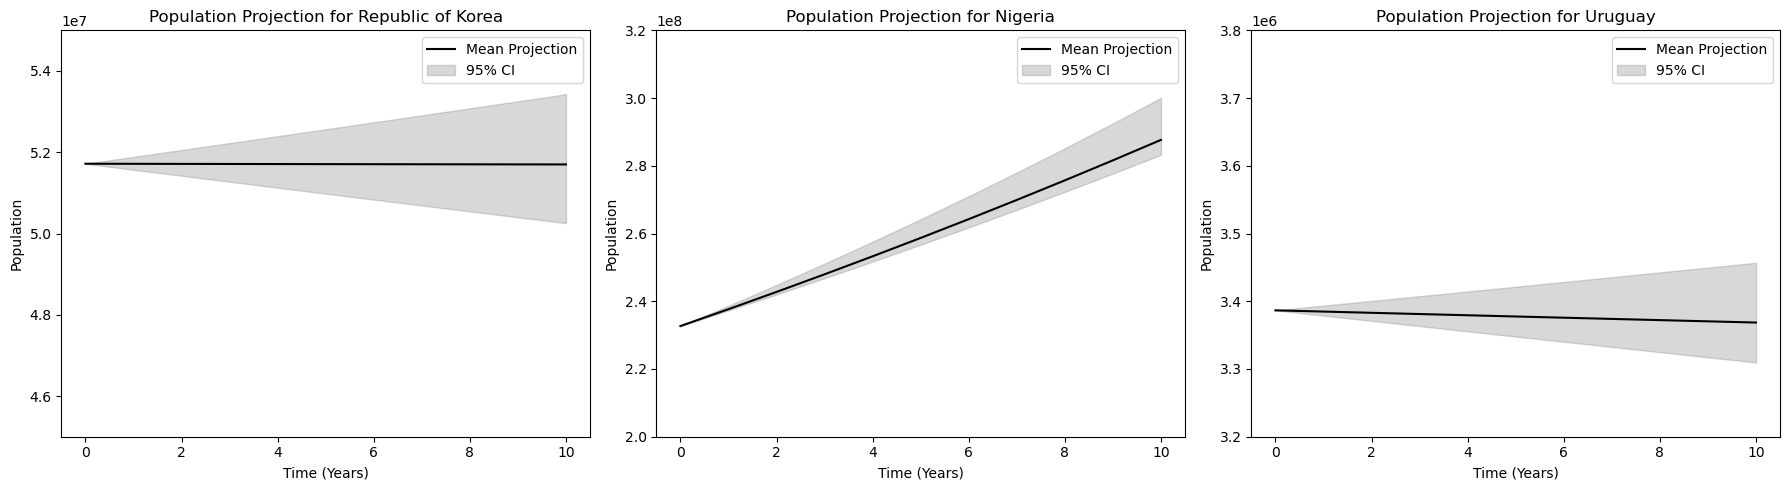

In [16]:
# Plot projections for each country with adjusted y-axis limits
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

y_limits = {
    "Republic of Korea": (45e6, 55e6),
    "Nigeria": (200e6, 320e6),
    "Uruguay": (3.2e6, 3.8e6)
}

for ax, country in zip(axes, populations.keys()):
    t_vals, mean_proj, lower_CI, upper_CI = bootstrap_population_projection(country)

    ax.plot(t_vals, mean_proj, label="Mean Projection", color='black')
    ax.fill_between(t_vals, lower_CI, upper_CI, color='gray', alpha=0.3, label="95% CI")
    
    ax.set_xlabel("Time (Years)")
    ax.set_ylabel("Population")
    ax.set_title(f"Population Projection for {country}")
    ax.set_ylim(y_limits[country])  # Set country-specific y-axis limits
    ax.legend()

plt.tight_layout()
plt.show()


In [18]:
# Store projections in a DataFrame
projection_data = []

for country in populations.keys():
    t_vals, mean_proj, _, _ = bootstrap_population_projection(country)
    
    for t, pop in zip(t_vals, mean_proj):
        projection_data.append({"Country": country, "Year": 2024 + t, "Projected Population": pop})

projection_df = pd.DataFrame(projection_data)

projection_df

,Country,Year,Projected Population
0,Republic of Korea,2024,5.171759e+07
1,Republic of Korea,2025,5.171674e+07
2,Republic of Korea,2026,5.171596e+07
3,Republic of Korea,2027,5.171527e+07
4,Republic of Korea,2028,5.171465e+07
5,Republic of Korea,2029,5.171412e+07
6,Republic of Korea,2030,5.171367e+07
7,Republic of Korea,2031,5.171329e+07
8,Republic of Korea,2032,5.171300e+07
9,Republic of Korea,2033,5.171279e+07
